# Bounds on Privacy Amplification by Shuffling
Based on **Balle, Bell, Gascón, and Nissim, *The Privacy Blanket of the Shuffle Model*, CRYPTO 2019**

This notebook illustrates the use of `amplification_bounds.py` to compute privacy bounds obtained from amplification by shuffling. We refer to the paper for details on how these bounds are obtained. The present implementation was used to produce the plots in the paper.

## Mechanisms

Most of the bounds in `amplification_bounds.py` use properties of specific mechanisms (ie. local randomizers). The classes in `mechanisms.py` implement the calculation of these properties for well-known mechanisms.

In [1]:
from mechanisms import *

# Bounds can be obtained for generic mechanisms satisfying pure local DP
generic = LDPMechanism()
# But bounds are usually better if they incorporate information about the specific randomizer
laplace = LaplaceMechanism()
# By default Randomized Response is over a set with two elements
rr = RRMechanism()
# But the class also accepts a paratemeter 'k' to determine the size of the alphabet
rrk = RRMechanism(k=100)

mechanisms = [generic, laplace, rr, rrk]

In [2]:
# By default all mechanisms are initialized to be 1-LDP
print(generic.get_eps0())
# This can be modified at construction or by calling set_eps0
eps0 = 4
for m in mechanisms:
    m.set_eps0(eps0)
print(generic.get_eps0())

1
4


In [3]:
# By giving a target epsilon ('eps') after shuffling we can compute properties
# of the privacy amplification random variable for each mechanism.
# These properties are used in the amplification bounds.
eps = 0.25
{m.get_name(): (m.get_gamma(), m.get_max_l(eps), m.get_range_l(eps), m.get_var_l(eps)) for m in mechanisms}

{'Generic': ((0.01831563888873418, 1),
  54.574632287288225,
  124.66172899508733,
  144.6152655550164),
 'Laplace': ((0.1353352832366127, 0.1353352832366127),
  7.215282155480206,
  16.567682708602117,
  12.415810765103338),
 'RR-2': ((0.03597241992418312, 0.03597241992418312),
  1.9178380785934013,
  4.403726990562285,
  4.928873289176336),
 'RR-100': ((0.6510495079427809, 0.6510495079427809),
  34.710134597944105,
  79.7011793024382,
  32.323385018018065)}

## Bounds

Several bounds are implements in `amplification_bounds.py`:
1. The closed-form bound of Erlingsson et al. [SODA'19]
2. A numeric bound based on Hoeffding's inequality
3. A numeric bound based on Bennett's inequality

In [4]:
from amplification_bounds import *

# This bound does not use infomation about the underlying mechanism
erlingsson = Erlingsson()
all_bounds = [erlingsson]

# The other two bounds can use a 'Generic' mechanism or a specific mechanism
bound_types = [Hoeffding, BennettExact]
for m in mechanisms:
    for B in bound_types:
        all_bounds.append(B(m))


In [5]:
# We can fix an eps0-LDP guarantee for a mechanism and shuffle n copies of it
n = 5000
eps0 = 0.4

# Then we can get a delta parameter for a target epsilon
print(erlingsson.get_delta(0.15, eps0, n))

# Numeric bounds admit a larger range of parameters than the closed-form bound
eps = 0.005
{b.get_name(): b.get_delta(eps, eps0, n) for b in all_bounds}

0.007575677444259949


{"EFMRTT'19": nan,
 'Hoeffding, Generic': 0.037942471911790294,
 'Bennett, Generic': 0.008339642506302775,
 'Hoeffding, Laplace': 0.005792337614227242,
 'Bennett, Laplace': 0.00023654709022709577,
 'Hoeffding, RR-2': 0.005642546362741425,
 'Bennett, RR-2': 0.0002827071819414499,
 'Hoeffding, RR-100': 0.007445148952583604,
 'Bennett, RR-100': 1.3473396238508272e-10}

In [6]:
# Bounds also be used to get an epsilon for a fixed delta
delta = 1e-6
{b.get_name(): b.get_eps(eps0, n, delta) for b in all_bounds}

{"EFMRTT'19": 0.2523130449483328,
 'Hoeffding, Generic': 0.05746164784348143,
 'Bennett, Generic': 0.07289999361525873,
 'Hoeffding, Laplace': 0.02423345457274603,
 'Bennett, Laplace': 0.015763502809793488,
 'Hoeffding, RR-2': 0.02397882347116631,
 'Bennett, RR-2': 0.016758539828689575,
 'Hoeffding, RR-100': 0.026881289729458715,
 'Bennett, RR-100': 0.0026771940444477024}

In [7]:
# Bounds can also be used for calibrating the eps0 parameter of a mechanism
# to achieve a target (eps,delta)-DP guarantee after shuffling
{b.get_name(): b.get_eps0(eps, n, delta) for b in all_bounds}

{"EFMRTT'19": 0.00792666110628386,
 'Hoeffding, Generic': 0.049635721235486374,
 'Bennett, Generic': 0.005,
 'Hoeffding, Laplace': 0.09927144247094191,
 'Bennett, Laplace': 0.1322952234971683,
 'Hoeffding, RR-2': 0.09933108921716256,
 'Bennett, RR-2': 0.12960673355421864,
 'Hoeffding, RR-100': 0.0970004939783926,
 'Bennett, RR-100': 0.6523204278217724}

## Plots

It is easier to compare the different bounds by plotting different parameters.

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_panel(f, xs, bounds, with_mech=True, debug=False):
    fig = plt.figure()
    for b in bounds:
        ys = list()
        for x in xs:
            if debug:
                print('{}: {}'.format(b.get_name(), x))
            ys.append(f(b, x))
        if with_mech:
            plt.plot(xs, ys, label=b.get_name())
        else:
            plt.plot(xs, ys, label=b.get_name(with_mech=False))
    plt.legend()

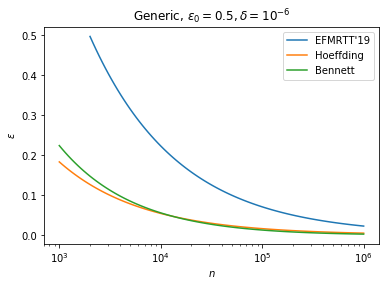

In [9]:
# How fast does eps decrease as we increase n?

eps0 = 0.5
delta = 1e-6
ns = np.geomspace(1000, 1000000, num=100, dtype=int)

def eps(bound, n):
    return bound.get_eps(eps0, n, delta)

bounds = [Erlingsson(),
          Hoeffding(LDPMechanism()),
          BennettExact(LDPMechanism())]

plot_panel(eps, ns, bounds, with_mech=False)
plt.xlabel('$n$')
plt.ylabel('$\\varepsilon$')
plt.title('Generic, $\\varepsilon_0 = {:.1f}, \\delta = 10^{}$'.format(eps0, '{-%d}' % np.log10(1/delta)))
plt.xscale('log')

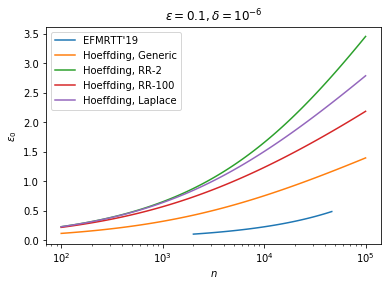

In [10]:
# How large can we set eps0 as the number of users increase?

eps = 0.1
delta = 1e-6
ns = np.geomspace(100, 100000, num=100, dtype=int)

def eps0(bound, n):
    return bound.get_eps0(eps, n, delta)

bounds = [Erlingsson(),
          Hoeffding(LDPMechanism()),
          Hoeffding(RRMechanism(k=2)),
          Hoeffding(RRMechanism(k=100)),
          Hoeffding(LaplaceMechanism())]

plot_panel(eps0, ns, bounds)
plt.xlabel('$n$')
plt.ylabel('$\\varepsilon_0$')
plt.title('$\\varepsilon = {:.1f}, \\delta = 10^{}$'.format(eps, '{-%d}' % np.log10(1/delta)))
plt.xscale('log')

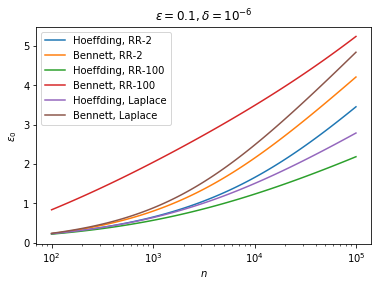

In [11]:
# How much better is the Bennett bound vs. the Hoeffding bound?

eps = 0.1
delta = 1e-6
ns = np.geomspace(100, 100000, num=100, dtype=int)

def eps0(bound, n):
    return bound.get_eps0(eps, n, delta)

mechanisms = [RRMechanism(),
              RRMechanism(k=100),
              LaplaceMechanism()]
Bounds = [Hoeffding,
          BennettExact]
bounds = []
for m in mechanisms:
    for B in Bounds:
        bounds.append(B(m))

plot_panel(eps0, ns, bounds, with_mech=True)
plt.xlabel('$n$')
plt.ylabel('$\\varepsilon_0$')
plt.title('$\\varepsilon = {:.1f}, \\delta = 10^{}$'.format(eps, '{-%d}' % np.log10(1/delta)))
plt.xscale('log')

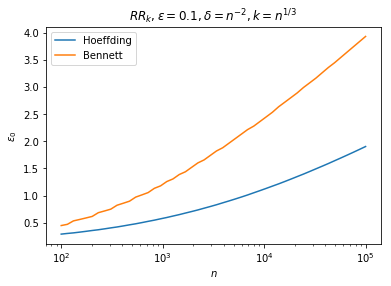

In [12]:
# What if k and delta depend on n?

eps = 0.1
ns = np.geomspace(100, 100000, num=50, dtype=int)

def eps0(bound, n):
    bound.mechanism.set_k(int(n**(1/3)))
    return bound.get_eps0(eps, n, 1.0/n**2)

bounds = [Hoeffding(RRMechanism()),
          BennettExact(RRMechanism())]

plot_panel(eps0, ns, bounds, with_mech=False)
plt.xlabel('$n$')
plt.ylabel('$\\varepsilon_0$')
plt.title('$RR_k, \\varepsilon = {}, \\delta = n^{}, k = n^{}$'.format(eps, '{-2}', '{1/3}'))
plt.xscale('log')